In [ ]:
from google.colab import drive

drive.mount('/content/gdrive/')

Drive already mounted at /content/gdrive/; to attempt to forcibly remount, call drive.mount("/content/gdrive/", force_remount=True).


In [ ]:
%cd /content/gdrive/MyDrive/ColabNotebooks/CapstoneBreath

/content/gdrive/MyDrive/ColabNotebooks/CapstoneBreath


In [ ]:
!pip install torchaudio soundfile
!pip install torch

# Введение

### Цель - Очистить музыку от шумов дыхания
Моя изначальная цель была очистка любой музыки от любого шума, но по ходу работы сделал компромисс сосредоточиться на очистку только от одного вида шума из за сложной структуры самой музыки которая состоит из различных инструментов, вокала итп. Что вышло бы за рамки моего бюджета на Capstone

### Источник музыки MUSDB18
https://sigsep.github.io/datasets/musdb.html
это широко используемая база данных для задач разделения источников в музыке (source separation). Она содержит 150 треков в формате многоканальных STEM-файлов (вокал, ударные, бас, аккомпанемент), каждый трек представлен в виде микса и отдельных инструментов. Датасет предназначен для обучения и оценки моделей, выделяющих вокал или инструменты из смешанного аудиосигнала.
Однако множество каналов для различных источников не используются в проекте и музыка приводится к одному каналу для простоты обучения

### Источник музыки
https://freesound.org/
Было использовано 22 разных шумов дыхания, 15 для train, 7 для test
На основе 15 шумов сделана аугментация, сгенерированно около 200 шумов
см блокнот Data Generation

In [ ]:
import os
from glob import glob
import time
import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch.nn.functional as F
import time
from tqdm import tqdm
import torchaudio
import random
import soundfile as sf
import numpy as np
import subprocess
from glob import glob
from torch.utils.data import Dataset
from pathlib import Path

In [ ]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
def convert_all_to_wav(folder):
    files = glob(os.path.join(folder, "*"))

    # Проверка: все ли уже .wav
    all_wav = all(file.lower().endswith(".wav") for file in files)
    if all_wav:
        print(f"✅ Все файлы в {folder} уже .wav — пропускаем.")
        return

    print(f"🔄 Конвертация файлов в {folder} в .wav формат...")

    for file in files:
        ext = os.path.splitext(file)[1].lower()
        name_wo_ext = os.path.splitext(os.path.basename(file))[0]

        tmp_output = os.path.join(folder, f"{name_wo_ext}.tmp.wav")
        final_output = os.path.join(folder, f"{name_wo_ext}.wav")

        # Конвертация в tmp
        !ffmpeg -y -i "{file}" -ac 1 -ar 16000 "{tmp_output}"

        # Удаляем исходный файл
        os.remove(file)

        # Переименовываем tmp → wav
        os.rename(tmp_output, final_output)

    print(f"✅ Конвертация завершена в {folder}")

In [ ]:
# convert_all_to_wav("noises/train")
# convert_all_to_wav("noises/test")
# convert_all_to_wav("musdb18/train")
# convert_all_to_wav("musdb18/test")

### 🗂️ Random File Selection
Выбор случайных файлов из каталогов `musdb`, `noises` и генерация зашумлённой дорожки.

In [ ]:
def load_audio(file_path, sr=16000):
    cmd = [
        "ffmpeg", "-i", file_path,
        "-f", "f32le", "-acodec", "pcm_f32le",
        "-ac", "1", "-ar", str(sr),
        "-hide_banner", "-loglevel", "error", "-"
    ]
    process = subprocess.Popen(cmd, stdout=subprocess.PIPE, stderr=subprocess.PIPE)
    raw_audio, _ = process.communicate()
    return np.frombuffer(raw_audio, np.float32)

def adjust_noise_length(noise, target_len):
    if len(noise) < target_len:
        repeats = int(np.ceil(target_len / len(noise)))
        noise = np.tile(noise, repeats)
    return noise[:target_len]

def mix_with_snr(clean, noise, snr_db):
    noise_power = np.mean(noise ** 2)
    clean_power = np.mean(clean ** 2)
    target_noise_power = clean_power / (10 ** (snr_db / 10))
    scaled_noise = noise * np.sqrt(target_noise_power / (noise_power + 1e-8))
    return clean + scaled_noise

def add_noise_to_folder_augmented(clean_folder, noise_folder, output_folder, snr_range=(0, 10), sr=16000, copies_per_track=3):
    os.makedirs(output_folder, exist_ok=True)

    clean_files = glob(os.path.join(clean_folder, "*"))
    noise_files = glob(os.path.join(noise_folder, "*.wav"))
    noisy_files = glob(os.path.join(output_folder, "*.wav"))

    if len(clean_files) <= len(noisy_files) and len(noisy_files) > 0:
        print(f"✅ Пропускаем {clean_folder} — уже {len(noisy_files)} зашумлённых треков.")
        return

    for clean_path in clean_files:
        filename = os.path.splitext(os.path.basename(clean_path))[0]
        print(f"🎧 Обработка {filename}")

        clean = load_audio(clean_path, sr=sr)

        for i in range(copies_per_track):
            noise_path = random.choice(noise_files)
            noise = load_audio(noise_path, sr=sr)

            noise = adjust_noise_length(noise, len(clean))
            snr = random.uniform(*snr_range)
            mixed = mix_with_snr(clean, noise, snr)

            output_name = f"{filename}_{i+1}.wav"
            output_path = os.path.join(output_folder, output_name)
            sf.write(output_path, mixed, sr)

    print("✅ Готово:", output_folder)

In [ ]:
# add_noise_to_folder_augmented(
#     clean_folder="musdb18/train",
#     noise_folder="noises/train",
#     output_folder="musdb_noisy/train"
# )

# add_noise_to_folder_augmented(
#     clean_folder="musdb18/test",
#     noise_folder="noises/test",
#     output_folder="musdb_noisy/test"
# )

### 🗂️ Random File Selection
Выбор случайных файлов из каталогов `musdb`, `noises` и генерация зашумлённой дорожки.

<ipython-input-10-c9d99f2da63d>:27: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127911 (\N{HEADPHONE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


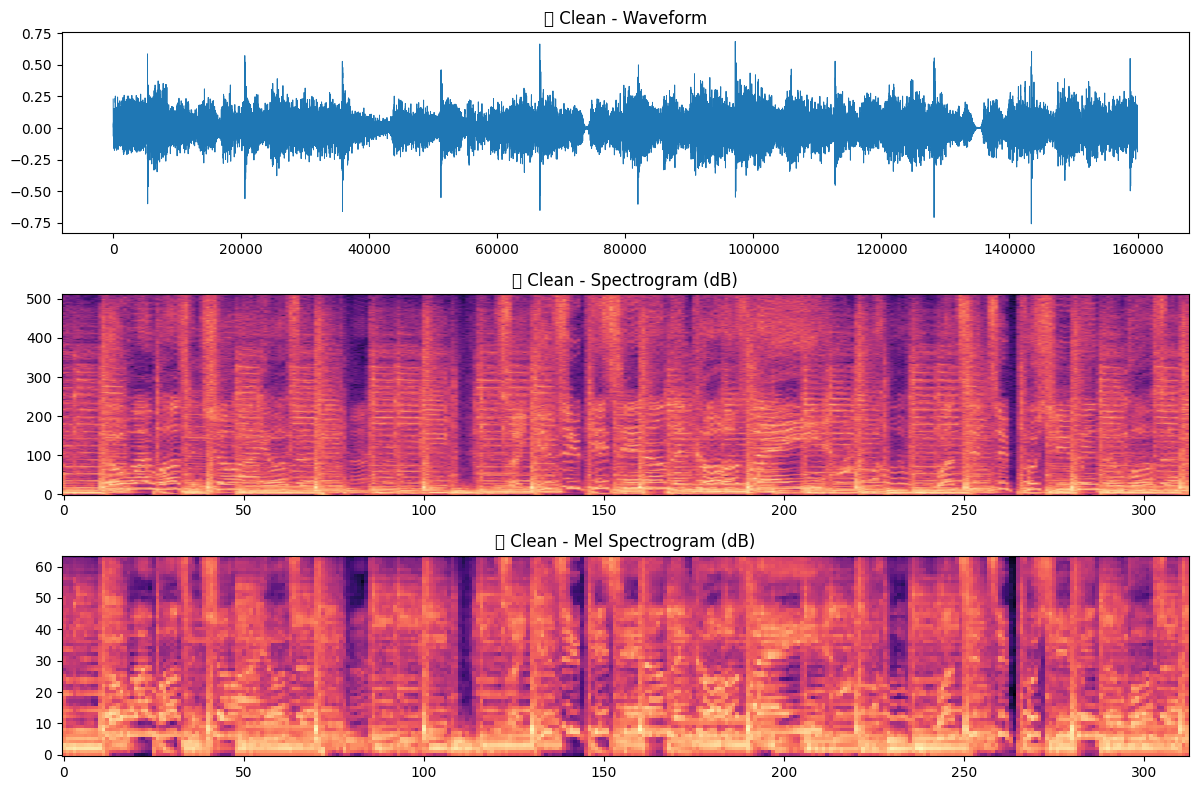

<ipython-input-10-c9d99f2da63d>:27: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


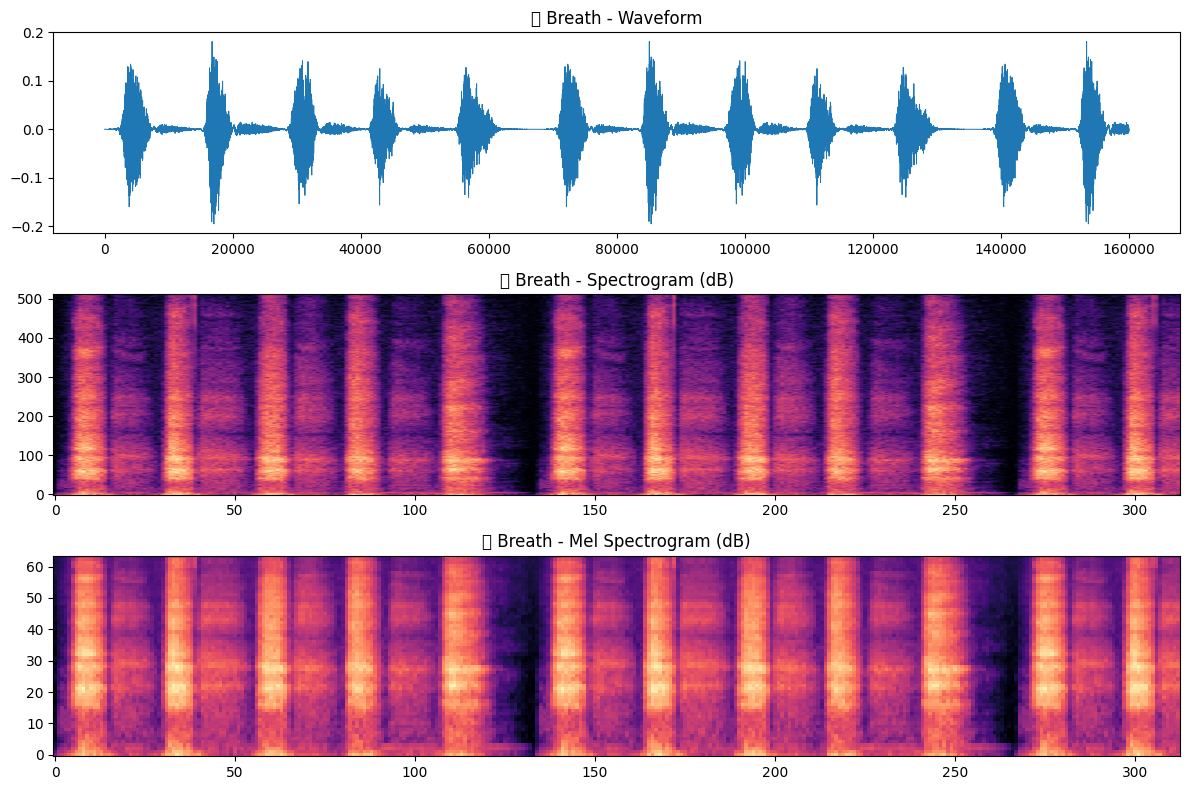

<ipython-input-10-c9d99f2da63d>:27: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 129514 (\N{TEST TUBE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


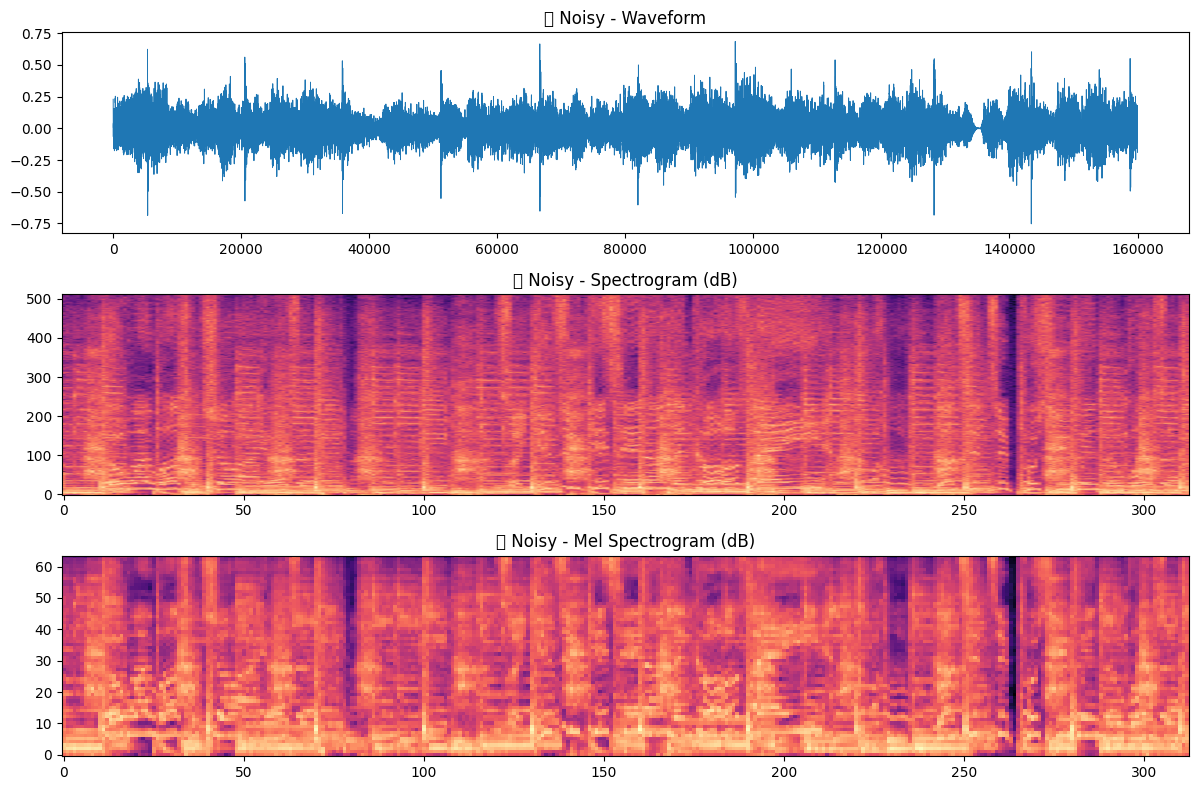

In [ ]:
import matplotlib.pyplot as plt
import torchaudio.transforms as T
import torch

# Трансформации
sr = 16000
spec = T.Spectrogram(n_fft=1024, hop_length=512, power=2)
mel_spec = T.MelSpectrogram(sample_rate=sr, n_fft=1024, hop_length=512, n_mels=64)

def plot_wave_and_spectrogram(wave, title, sr):
    fig, axs = plt.subplots(3, 1, figsize=(12, 8))

    # Волна
    axs[0].plot(wave[0].numpy(), linewidth=0.7)
    axs[0].set_title(f"{title} - Waveform")

    # Спектрограмма
    S = spec(wave)
    axs[1].imshow(10 * torch.log10(S + 1e-7)[0].numpy(), origin="lower", aspect="auto", cmap="magma")
    axs[1].set_title(f"{title} - Spectrogram (dB)")

    # Мел-спектрограмма
    M = mel_spec(wave)
    axs[2].imshow(10 * torch.log10(M + 1e-7)[0].numpy(), origin="lower", aspect="auto", cmap="magma")
    axs[2].set_title(f"{title} - Mel Spectrogram (dB)")

    plt.tight_layout()
    plt.show()


clean_dir = "musdb18/test"
noisy_dir = "musdb_noisy/test"
noise_dir = "noises/test"

# Вспомогательная функция — выбор случайного файла
def random_audio_file(directory):
    supported_ext = ('.wav', '.flac', '.mp3', '.ogg')
    all_files = [os.path.join(dp, f) for dp, _, files in os.walk(directory) for f in files if f.endswith(supported_ext)]
    return random.choice(all_files)

# Выбор
clean_path = random_audio_file(clean_dir)
breath_path = random_audio_file(noise_dir)
import torchaudio
import torch

# 1. Загрузка аудио
clean_wave, sr = torchaudio.load(clean_path)
breath_wave, _ = torchaudio.load(breath_path)

# 2. Вырезаем 10 секунд из центра clean_wave
target_samples = 10 * sr
total_len = clean_wave.shape[-1]
start = max((total_len - target_samples) // 2, 0)
clean_wave = clean_wave[:, start:start + target_samples]

# 3. Зацикливаем дыхание до нужной длины
breath_wave = breath_wave[:1]  # оставим 1 канал
breath_repeats = (target_samples // breath_wave.shape[-1]) + 1
breath_wave = breath_wave.repeat(1, breath_repeats)[:, :target_samples]

# 4. Нормализация дыхания и создание зашумлённого сигнала
scaled_breath = breath_wave / breath_wave.abs().max() * 0.3
noisy_wave = clean_wave + scaled_breath
noisy_wave = torch.clamp(noisy_wave, -1.0, 1.0)  # защита от клиппинга


plot_wave_and_spectrogram(clean_wave, "🎧 Clean", sr)
plot_wave_and_spectrogram(breath_wave, "🌬️ Breath", sr)
plot_wave_and_spectrogram(noisy_wave, "🧪 Noisy", sr)

<b>Музыка</b>  
Waveform (сверху):  
Акустически насыщенная структура — возможно, вокал + инструменты.
Динамика умеренная, без сильных пиков или обрезания (клиппинга нет).  

Spectrogram (середина):  
Хорошо различимая гармоническая структура.
Энергия присутствует во всех диапазонах, особенно в нижне-среднем (100–3000 Гц).  

Mel Spectrogram (внизу):  
Подтверждает наличие гармоник.
Явно различимая звуковая активность на всех частотах.

<b>Шум</b>  
Waveform:  
Неровная, прерывистая структура.
Характерны всплески и паузы — типичный "захватывающий" или "выпускающий" воздух.
Амплитуда ниже, чем у clean, особенно если дыхание было ослаблено до 0.3.

Spectrogram:  
Энергия сосредоточена в низких и нижне-средних частотах (от ~100 до 1500 Гц).
Шумовая структура, без выраженных гармоник.

Mel Spectrogram:  
Также подтверждает шумовую природу — широкополосное заполнение, без чётких линий.
Видна импульсная активность (вдохи/выдохи).

<b>Зашумлённая музыка</b>  
Waveform:  
Форма почти идентична clean_wave, но видны лёгкие искажения в местах дыхания.
Пиков нет — значит, нормализация и clamp сработали хорошо.

Spectrogram:  
Общее распределение частот осталось, но появилась дополнительная энергия в нижних частотах.
Сравнение с clean показывает усиление в области до 1–1.5 кГц.

Mel Spectrogram:  
Добавлены "туманные" области внизу — дыхание внесло шумовые включения.
Хорошо видно, как дыхание размазывает низкие частоты, делая спектр более заполненным.

📌 Этот график подтверждает, что дыхание:
- не нарушает гармоническую структуру,
- но добавляет плотность в нижний частотный диапазон,
- и может быть отделено как по амплитуде, так и по спектру.

### 🔢 Расчёт SNR
Вычисление отношения сигнал/шум для оценки качества зашумлённой дорожки.

In [ ]:
def rms(waveform):
    return torch.sqrt(torch.mean(waveform ** 2))

def compute_snr(clean, noisy):
    noise = noisy - clean
    signal_power = torch.mean(clean ** 2)
    noise_power = torch.mean(noise ** 2)
    snr = 10 * torch.log10(signal_power / (noise_power + 1e-8))
    return snr.item()

# RMS значения
rms_clean = rms(clean_wave).item()
rms_noisy = rms(noisy_wave).item()
rms_breath = rms(breath_wave).item()

# SNR между clean и noisy
snr_value = compute_snr(clean_wave, noisy_wave)

# Вывод
print(f"🔊 RMS Clean       : {rms_clean:.4f}")
print(f"🔊 RMS Noisy       : {rms_noisy:.4f}")
print(f"🌬️ RMS Breath Noise: {rms_breath:.4f}")
print(f"📏 SNR (Clean vs Noisy): {snr_value:.2f} dB")

🔊 RMS Clean       : 0.0957
🔊 RMS Noisy       : 0.1006
🌬️ RMS Breath Noise: 0.0203
📏 SNR (Clean vs Noisy): 9.76 dB


✅ **Вывод:** Зафиксированное значение SNR помогает оценить степень зашумления и может использоваться для мониторинга эффективности модели очистки.

# *Разница спектрограммы*

📏 Mel L1 Difference: 3.4377
📏 Mel L2 Difference: 15.6126


<ipython-input-12-73003daa3ea0>:25: UserWarning: Glyph 127788 (\N{WIND BLOWING FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()


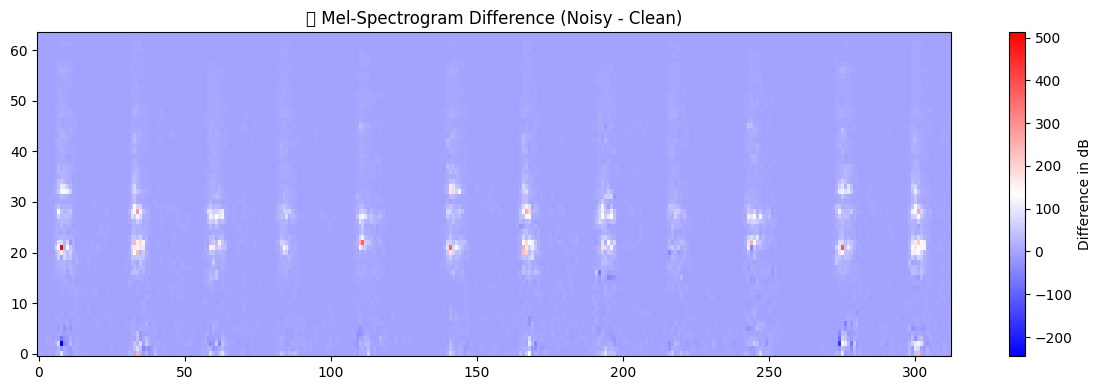

In [ ]:
import torchaudio.transforms as T
import matplotlib.pyplot as plt

# Трансформации
mel_transform = T.MelSpectrogram(sample_rate=sr, n_fft=1024, hop_length=512, n_mels=64)

# Mel-спектрограммы
mel_clean = mel_transform(clean_wave)
mel_noisy = mel_transform(noisy_wave)

# Разница
diff = mel_noisy - mel_clean
l1_diff = torch.mean(torch.abs(diff)).item()
l2_diff = torch.sqrt(torch.mean(diff ** 2)).item()

# Вывод метрик
print(f"📏 Mel L1 Difference: {l1_diff:.4f}")
print(f"📏 Mel L2 Difference: {l2_diff:.4f}")

# Визуализация
plt.figure(figsize=(12, 4))
plt.imshow(diff[0].numpy(), aspect="auto", origin="lower", cmap="bwr", interpolation="none")
plt.title("🌬️ Mel-Spectrogram Difference (Noisy - Clean)")
plt.colorbar(label="Difference in dB")
plt.tight_layout()
plt.show()


💡 На данном этапе будет сложно опираться на спектральную разницу, будем использовать спектрограмму в обучении после сведения модели по временным признакам

### 🎛️ RMS и Zero-Crossing Rate
Извлечение амплитудных и частотных характеристик для генерации маски шума.

<ipython-input-13-0a0e89ff63e3>:47: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128266 (\N{SPEAKER WITH THREE SOUND WAVES}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


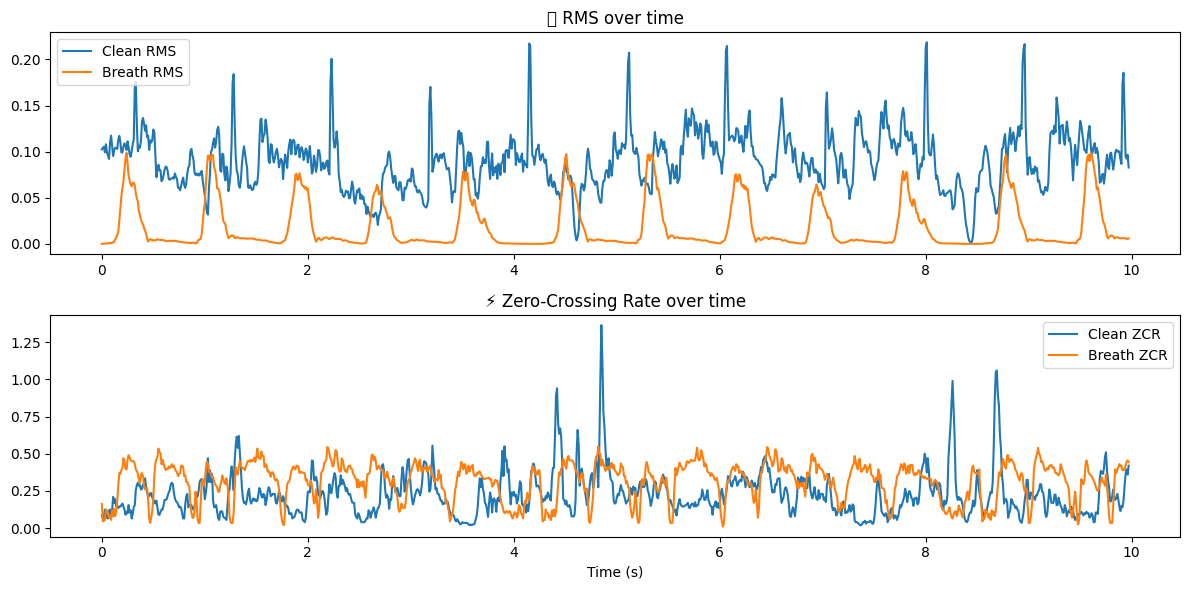

In [ ]:
import torch.nn.functional as F
import matplotlib.pyplot as plt

def sliding_rms(waveform, frame_size, hop_size):
    waveform_sq = waveform ** 2
    window = torch.ones(1, 1, frame_size)
    rms = torch.sqrt(F.conv1d(waveform_sq.unsqueeze(0), window, stride=hop_size) / frame_size)
    return rms.squeeze()

def zero_crossing_rate(waveform, frame_size, hop_size):
    # Убедимся, что размер [1, T]
    if waveform.ndim == 2:
        waveform = waveform[0]  # [T]
    sign_changes = torch.diff(torch.sign(waveform)).abs().unsqueeze(0).unsqueeze(0)  # [1, 1, T-1]
    window = torch.ones(1, 1, frame_size)
    zcr = F.conv1d(sign_changes, window, stride=hop_size) / frame_size
    return zcr.squeeze()


# Параметры окон
frame_size = int(0.025 * sr)  # 25 мс
hop_size = int(0.010 * sr)    # 10 мс

# Расчёт
rms_clean = sliding_rms(clean_wave, frame_size, hop_size)
rms_breath = sliding_rms(scaled_breath, frame_size, hop_size)
zcr_clean = zero_crossing_rate(clean_wave, frame_size, hop_size)
zcr_breath = zero_crossing_rate(scaled_breath, frame_size, hop_size)

# Визуализация
t = torch.arange(rms_clean.shape[0]) * hop_size / sr

plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(t, rms_clean.numpy(), label="Clean RMS")
plt.plot(t, rms_breath.numpy(), label="Breath RMS")
plt.title("🔊 RMS over time")
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(t, zcr_clean.numpy(), label="Clean ZCR")
plt.plot(t, zcr_breath.numpy(), label="Breath ZCR")
plt.title("⚡ Zero-Crossing Rate over time")
plt.legend()

plt.xlabel("Time (s)")
plt.tight_layout()
plt.show()

✅ **Вывод:** RMS и Zero-Crossing дают полезные индикаторы для обнаружения слабых и ритмичных дыхательных шумов, что позволяет формировать разумную маску.

### 🎛️ RMS и Zero-Crossing Rate
Извлечение амплитудных и частотных характеристик для генерации маски шума.

<ipython-input-14-991f5437b3b8>:20: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.11/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 127917 (\N{PERFORMING ARTS}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


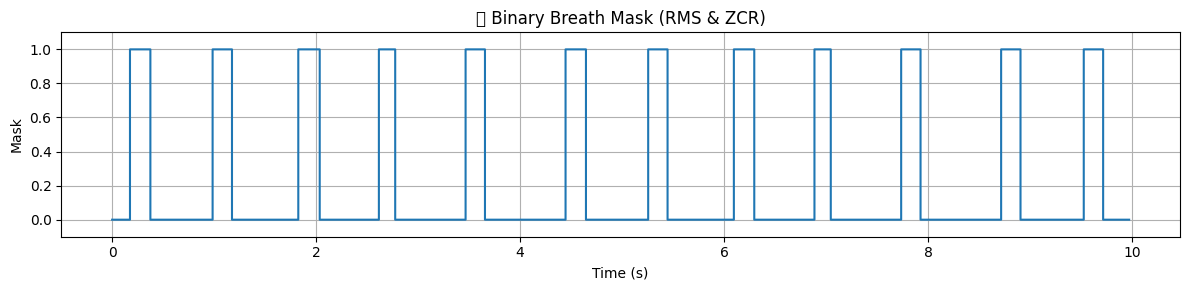

In [ ]:
# Пороговые значения — можно подстроить по визуализации
RMS_THRESHOLD = 0.03
ZCR_THRESHOLD = 0.2

rms_breath = sliding_rms(scaled_breath, frame_size, hop_size)
zcr_breath = zero_crossing_rate(scaled_breath, frame_size, hop_size)

mask = ((rms_breath > RMS_THRESHOLD) & (zcr_breath > ZCR_THRESHOLD)).float()

# 3. Визуализация маски
t = torch.arange(mask.shape[0]) * hop_size / sr

plt.figure(figsize=(12, 3))
plt.plot(t, mask.numpy(), drawstyle="steps-mid")
plt.title("🎭 Binary Breath Mask (RMS & ZCR)")
plt.xlabel("Time (s)")
plt.ylabel("Mask")
plt.ylim(-0.1, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()


✅ Вот так будет выглядеть маска которую будем использовать для loss функции, она призвана минимизировать сложность сравнения двух волн